In [21]:
import numpy as np
import pandas as pd
from scipy import stats


import statsmodels.tsa.stattools as ts


import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
import statsmodels.stats as sms

import matplotlib.pyplot as plt
import matplotlib as mpl



# 引入Kalman函数库
from pykalman import KalmanFilter

# 引入纯随机序列检测，只有是非纯随机序列，才能进行检测
from statsmodels.stats.diagnostic import acorr_ljungbox

# 引入时序分析模型进行模型匹配
from statsmodels.tsa.arima_model import ARMA

# 导入函数

In [22]:
# S1为自变量，S2为因变量
def kalman_beta(S1,S2):
    
    # 观察矩阵
    # 注意：
    # 1、观察到的是sec1数据，sec1是自变量x，sec2是因变量y
    # 2、需要使用add_constant来模拟alpha
    # 3、需要使用np.newaxis来增加维度
    obs_mat = sm.add_constant(S1.values, prepend=False)[:, np.newaxis]

    kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, # y is 1-dimensional, (alpha, beta) is 2-dimensional
                  initial_state_mean=np.ones(2),
                  initial_state_covariance=np.ones((2, 2)),
                  transition_matrices=np.eye(2),  # 不发生变化，都是单位矩阵
                  observation_matrices=obs_mat,   # 观察矩阵
                  observation_covariance=10**2,
                  transition_covariance=0.01**2 * np.eye(2))
    
    # 相当于使用sec2来进行训练，模拟出beta、alpha
    state_means, state_covs = kf.filter(S2[:, np.newaxis])
    
    # 第一个参数为beta，第二个参数为alpha
    return state_means[-1]



# 进行画图，判断AR、MA的延迟阶数

def tsplot(y, lags=None, figsize=(15, 10), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return


# 函数名：Cadf_test
# 输入参数：
# 1、res_pd:pandas数组，index为日期，列名为“res”
# 输出参数：
# P value：返回test的p值，用于后续监测
# null hypothesis of the Augmented Dickey-Fuller is that there is a unit root

def Cadf_test(res):

    # 使用adf计算adf的值
    cadf = ts.adfuller(res)
    
    return cadf[1]


# 重要：只有时间序列不是一个白噪声（纯随机序列）的时候，该序列才可做分析
# 函数名：test_stochastic
# 输入参数：
# 1、res_pd:pandas数组，index为日期，列名为“res”
# 输出参数：
# P value：返回test的p值，用于后续监测
# Ljung-Box test for no autocorrelation
# 纯随机性检验,p值小于5%,序列为非白噪声
# H0: 原本的数据都是纯随机序列
# 用于检验某个时间段内的一系列观测值是不是随机的独立观测值
# 如果观测值并非彼此独立，一个观测值可能会在 i 个时间单位后与另一个观测值相关，形成一种称为自相关的关系
# 自相关可以削减基于时间的预测模型（例如时间序列图）的准确性，并导致数据的错误解释。

def test_stochastic(ts):
    p_value = acorr_ljungbox(ts)[1] #lags可自定义
    return p_value[0]


# 生成持仓序列
# 输入：
# buy_list:[0,....,1,0,...]
# sell_list:[0,...-1,0,-1....]
# 相互融合后生成持仓序列：[0,0,....1,0,1,....]

def position_generate(buy_list,sell_list):
    # 生成混合序列
    combine_list = np.array(buy_list) + np.array(sell_list)


    # 生成状态序列
    state_list = []
    # 1、初始化第一个状态，如果是0则设置为-1，如果是-1则保持-1，如果是1则保持1
    if combine_list[0] == 0:
        state_list.append(-1)
    else:
        state_list.append(combine_list[0])

    # 2、开始设置后续的状态，如果是0则设置为前一个状态，如果当前状态与前一个状态不同，则设置为当前状态
    for state in combine_list[1:]:
        if state == 0:
            state_list.append(state_list[-1])
        else:
            state_list.append(state)

    # 进行异或操作
    xor_list = []
    for i in range(len(state_list)):
        if state_list[i] == np.array(pd.Series(state_list).shift(1).fillna(-1))[i]:
            xor_list.append(0)
        else:
            xor_list.append(1)

    # 生成新的买入、卖出数组
    buy_point_new = np.array(buy_list) * xor_list
    sell_point_new = np.array(sell_list) * xor_list

    # 生成新的混合数组
    combine_list_new = buy_point_new + sell_point_new
    
    # 调试
    # 因为是在收盘时交易，所以要调整1位
    # 如果在开盘交易，则不需要调整
    ret_list = list(np.cumsum(combine_list_new))
    ret_list.insert(0,0)
    ret_list.pop(len(ret_list)-1)
    
    
    
    return np.array(ret_list)

In [23]:
A = [1,1,1,1,1,1,1,1]

In [24]:
a = [i for i in range(10)]
a

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [25]:
a.pop(2)
a.append(11)
a

[0, 1, 3, 4, 5, 6, 7, 8, 9, 11]

# 求出参数

In [117]:
end_date = '2018-10-31'
ncount = 500

# S1为自变量，是观察值
# S2为因变量，是操作值


sec1 = '000300.XSHG'
sec2 = '600104.XSHG'

sec2 = '000651.XSHE'
sec2 = '300157.XSHE'
sec2 = '601939.XSHG'

# 观测参数
S1 = get_price(sec1, count =  ncount, end_date= end_date, frequency='1d', fields='close',fq = "none")['close']
P = S1/S1.shift(1)
P = P.fillna(1)

# 操作参数
S2 = get_price(sec2, count =  ncount, end_date= end_date, frequency='1d', fields='close',fq = "none")['close']
Q = S2/S2.shift(1)
Q = Q.fillna(1)


In [118]:
# 计算alpha、beta
# 按照定义：S1为自变量，S2为因变量
beta_kf = kalman_beta(P,Q)
beta = kalman_beta(P,Q)[0]
alpha = kalman_beta(P,Q)[1]
print(beta,alpha)

0.5221588203861585 0.5221491376931959


In [119]:
res = Q - np.dot(sm.add_constant(P, prepend=False), beta_kf)

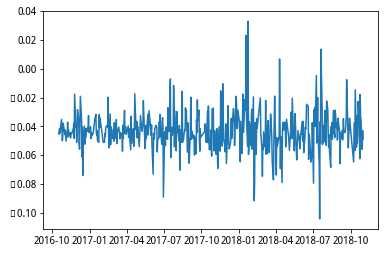

In [120]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(list(res.index),list(res.values))
plt.show()

In [121]:
np.mean(res)

-0.043512920472648715

In [122]:
Cadf_test(res)

0.0

H0：there is unit root

因为概率低于0.05，所以可以推翻H0

结论：不存在Unit Root

In [123]:
test_stochastic(res)

0.159851874147674

H0：原本的数据都是纯随机序列

因为概率高于0.05，所以不可以推翻H0

结论：序列是纯随机序列

In [124]:
std_deviation = np.std(res)
mean = np.mean(res)
print(mean,std_deviation)

-0.043512920472648715 0.013390782343794939


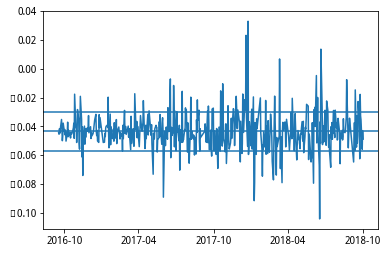

-0.043512920472648715

In [125]:
import matplotlib.dates as mdate 

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(list(res.index),list(res.values))


# 设置时间日期格式
ax.xaxis.set_major_formatter(mdate.DateFormatter('%Y-%m'))#设置时间标签显示格式
plt.xticks(pd.date_range(list(res.index)[0],list(res.index)[-1],freq='6M'))  

ax.axhline(mean+std_deviation)
ax.axhline(mean-std_deviation)
ax.axhline(mean)

plt.show()

mean

# 开始验证

In [126]:
start_date = '2018-1-1'
end_date = '2019-1-20'

# 指数,P
S1_validation = get_price(sec1, start_date =  start_date, end_date= end_date, frequency='1d', fields='close',fq = "none")['close']
P_validation = S1_validation/S1_validation.shift(1)
P_validation = P_validation.fillna(1)


# 个股,Q
S2_validation = get_price(sec2, start_date =  start_date, end_date= end_date, frequency='1d', fields='close',fq = "none")['close']
Q_validation = S2_validation/S2_validation.shift(1)
Q_validation = Q_validation.fillna(1)

In [127]:
Q_infer = beta*P_validation + alpha

gap = Q_validation - Q_infer 


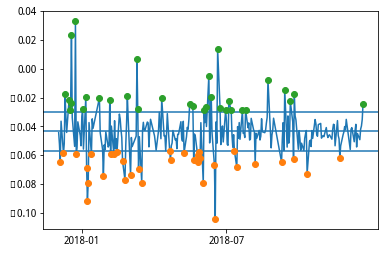

In [128]:
import matplotlib.dates as mdate 

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(list(gap.index),list(gap.values))


# 设置时间日期格式
ax.xaxis.set_major_formatter(mdate.DateFormatter('%Y-%m'))#设置时间标签显示格式
plt.xticks(pd.date_range(list(gap.index)[0],list(gap.index)[-1],freq='6M'))  

ax.axhline(mean+std_deviation)
ax.axhline(mean-std_deviation)
ax.axhline(mean)



# 添加交易点

Date_plot = gap.index
Data_plot = gap.values

pos_buy = (gap < (mean-std_deviation) )
pos_sell = (gap > (mean + std_deviation) )

plt.plot_date(Date_plot[pos_buy],Data_plot[pos_buy],'o')
plt.plot_date(Date_plot[pos_sell],Data_plot[pos_sell],'o') 


plt.show()


# 策略推导

gap = Q_validation - Q_infer 

说明：
1. Q_infer是观测到推导值，Q_validation是实际值
2. 两者之差gap实际上是推导值与实际值之间的差距
3. 运算为实际值减去推导值，如果小于下限 => 推导值高，实际值低 => gap值要回归到0 => 要么推导值变小，要么实际值变大

结论：

所以在gap小于下限的情况下：
- 实际值最终会变大
- 推导值变小，推导值变小意味着alpha、beta不变的情况下，P变小，P变小意味着指数的收益率降低（做空的时机）

In [129]:
# 序列处理代码实现
# buy_point_pd = gap < mean - 1*std_deviation
# sell_point_pd = gap > mean + 1*std_deviation

buy_point_pd  = gap < mean - 0.5*std_deviation
sell_point_pd = gap > mean + 0.5*std_deviation

buy_point_list = [int(d) for d in buy_point_pd ]
sell_point_list = [-int(d) for d in sell_point_pd ]



In [130]:
# 画出推测标的的收益率曲线
S1_Yield = np.cumsum((np.log(S1_validation) - np.log(S1_validation.shift(1)) ))

S2_Yield = np.cumsum((np.log(S2_validation) - np.log(S2_validation.shift(1)) )*position_generate(buy_point_list,sell_point_list))


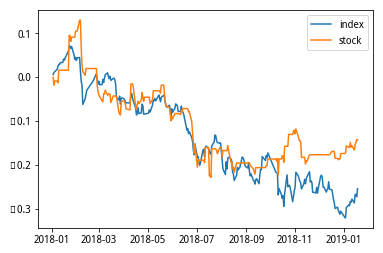

In [131]:
import matplotlib.dates as mdate 

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(S1_Yield.index,S1_Yield.values,label='index')
ax.plot(S2_Yield.index,S2_Yield.values,label='stock')

plt.legend()

# 与策略数据进行验证

按照该算法是在每天收盘结束后进行计算

依照收盘价买入，在第二天操作，相当于盘后操作

In [112]:
# 打印相应的参数
print(alpha,beta,mean,std_deviation)

0.5212167456194894 0.5212291931468367 -0.0435091899670243 0.02850613464563515


In [113]:
S2_Yield.index[np.where(np.array(sell_point_list) == -1)]

DatetimeIndex(['2018-01-03', '2018-01-09', '2018-01-17', '2018-02-06',
               '2018-02-23', '2018-02-27', '2018-03-01', '2018-03-08',
               '2018-03-09', '2018-03-12', '2018-03-13', '2018-03-22',
               '2018-03-27', '2018-03-28', '2018-03-29', '2018-03-30',
               '2018-04-03', '2018-04-12', '2018-04-19', '2018-05-07',
               '2018-05-08', '2018-05-09', '2018-05-11', '2018-05-17',
               '2018-05-18', '2018-05-29', '2018-05-31', '2018-06-05',
               '2018-06-06', '2018-06-25', '2018-06-27', '2018-07-03',
               '2018-07-06', '2018-07-09', '2018-07-26', '2018-07-31',
               '2018-08-07', '2018-08-08', '2018-08-14', '2018-08-24',
               '2018-08-29', '2018-09-06', '2018-09-11', '2018-09-13',
               '2018-09-17', '2018-09-19', '2018-10-08', '2018-10-09',
               '2018-10-22', '2018-10-26', '2018-10-30', '2018-11-05',
               '2018-11-12', '2018-11-13', '2018-11-15', '2018-11-19',
      

In [114]:

print(S2_validation['2018-12-28'])
print(S2_validation['2018-12-27'])
print(Q_validation['2018-12-28'])


print(S1_validation['2018-12-28'])
print(S1_validation['2018-12-27'])
print(Q_infer['2018-12-28'])



print(gap['2018-12-28'])

# S1_validation = get_price(sec1, start_date =  start_date, end_date= end_date, frequency='1d', fields='close',fq = "none")['close']
# P_validation = S1_validation/S1_validation.shift(1)
# P_validation = P_validation.fillna(1)


# # 个股,Q
# S2_validation = get_price(sec2, start_date =  start_date, end_date= end_date, frequency='1d', fields='close',fq = "none")['close']
# Q_validation = S2_validation/S2_validation.shift(1)

4.15
4.18
0.9928229665071772
3010.65
2990.51
1.045956228298873
-0.05313326179169586


In [95]:
# 确定对应持仓时刻的下标
S2_Yield.index[np.where(position_generate(buy_point_list,sell_point_list) ==1)]

DatetimeIndex(['2018-01-17', '2018-01-18', '2018-01-19', '2018-01-22',
               '2018-01-25', '2018-01-26', '2018-01-30', '2018-01-31',
               '2018-02-06', '2018-02-07',
               ...
               '2018-11-27', '2018-11-28', '2018-12-03', '2018-12-06',
               '2018-12-07', '2018-12-10', '2018-12-11', '2018-12-12',
               '2018-12-13', '2019-01-18'],
              dtype='datetime64[ns]', length=122, freq=None)

In [96]:
# 以‘2018-10-30’作为样本进行测试
# 前一天为‘2018-12-27’
trade_day = '2018-12-28'
trade_day_pre = '2018-12-27'

# 求出gap值相关的参数
# 公式如下：
# gap = Q_validation - Q_infer 
# 指数,P
# S1_validation = get_price(sec1, start_date =  start_date, end_date= end_date, frequency='1d', fields='close',fq = "pre")['close']
# P_validation = S1_validation/S1_validation.shift(1)
# P_validation = P_validation.fillna(1)
# 个股,Q
# S2_validation = get_price(sec2, start_date =  start_date, end_date= end_date, frequency='1d', fields='close',fq = "pre")['close']
# Q_validation = S2_validation/S2_validation.shift(1)
# Q_validation = Q_validation.fillna(1)

print(S2_validation[trade_day])
print(S2_validation[trade_day_pre])
print(S2_validation[trade_day]/S2_validation[trade_day_pre])


print(S1_validation[trade_day])
print(S1_validation[trade_day_pre])
print(S1_validation[trade_day]/S1_validation[trade_day_pre])

gap_trade_day = S2_validation[trade_day]/S2_validation[trade_day_pre] - beta * S1_validation[trade_day]/S1_validation[trade_day_pre] - alpha
print(gap_trade_day)

35.69
35.68
1.000280269058296
3010.65
2990.51
1.0067346372357893
-0.04803498766330805


sell_point_pd = gap < mean - 0.5*std_deviation

buy_point_pd = gap > mean + 0.5*std_deviation

In [69]:
mean - 0.5*std_deviation

-0.05118836911353614

In [70]:
mean + 0.5*std_deviation

-0.03574153948826685

In [71]:
data_total_pd = pd.DataFrame()

In [72]:
pos_pd =pd.Series(position_generate(buy_point_list,sell_point_list))
pos_pd.index =S2_validation.index

In [73]:

data_total_pd = pd.concat([data_total_pd,
                            S1_validation,
                            S1_validation.shift(1).iloc[0:S1_validation.shape[0]],
                            S1_validation/S1_validation.shift(1).iloc[0:S1_validation.shape[0]],

                            S2_validation,
                            S2_validation.shift(1).iloc[0:S2_validation.shape[0]],
                            S2_validation/S2_validation.shift(1).iloc[0:S1_validation.shape[0]],
                            gap,
                            pos_pd
                          
                          ],
                          axis=1)

data_total_pd.columns = ['S1','S1_pre','S1_yield','S2','S2_pre','S2_yield','gap','pos']

print(S1_validation.shape[0])
data_total_pd

256


,S1,S1_pre,S1_yield,S2,S2_pre,S2_yield,gap,pos
2018-01-02,4087.40,NaN,NaN,31.77,NaN,NaN,-0.044031,0
2018-01-03,4111.39,4087.40,1.005869,31.53,31.77,0.992446,-0.054649,0
2018-01-04,4128.81,4111.39,1.004237,31.63,31.53,1.003172,-0.043072,1
2018-01-05,4138.75,4128.81,1.002407,31.92,31.63,1.009169,-0.036120,1
2018-01-08,4160.16,4138.75,1.005173,32.41,31.92,1.015351,-0.031381,1
2018-01-09,4189.30,4160.16,1.007005,32.44,32.41,1.000926,-0.046762,0
2018-01-10,4207.81,4189.30,1.004418,33.87,32.44,1.044081,-0.002256,0
2018-01-11,4205.59,4207.81,0.999472,33.83,33.87,0.998819,-0.044937,0
2018-01-12,4225.00,4205.59,1.004615,33.91,33.83,1.002365,-0.044076,0
2018-01-15,4225.24,4225.00,1.000057,33.50,33.91,0.987909,-0.056152,0


In [74]:
data_total_pd["S1_yield_sum"] = np.exp(np.cumsum(np.log(data_total_pd['S1_yield'])))
data_total_pd["S2_yield_sum"] = np.exp(np.cumsum(np.log(data_total_pd['S2_yield'])))


In [75]:
S2_yield_sum = data_total_pd['S2_yield']*data_total_pd['pos']
S2_yield_sum = S2_yield_sum.fillna(1)
S2_yield_sum = S2_yield_sum.replace(0, 1)
data_total_pd['S2_yield_sum_adjust'] = np.exp(np.cumsum(np.log(S2_yield_sum)))


In [76]:
data_total_pd

,S1,S1_pre,S1_yield,S2,S2_pre,S2_yield,gap,pos,S1_yield_sum,S2_yield_sum,S2_yield_sum_adjust
2018-01-02,4087.40,NaN,NaN,31.77,NaN,NaN,-0.044031,0,NaN,NaN,1.000000
2018-01-03,4111.39,4087.40,1.005869,31.53,31.77,0.992446,-0.054649,0,1.005869,0.992446,1.000000
2018-01-04,4128.81,4111.39,1.004237,31.63,31.53,1.003172,-0.043072,1,1.010131,0.995593,1.003172
2018-01-05,4138.75,4128.81,1.002407,31.92,31.63,1.009169,-0.036120,1,1.012563,1.004721,1.012369
2018-01-08,4160.16,4138.75,1.005173,32.41,31.92,1.015351,-0.031381,1,1.017801,1.020145,1.027910
2018-01-09,4189.30,4160.16,1.007005,32.44,32.41,1.000926,-0.046762,0,1.024930,1.021089,1.027910
2018-01-10,4207.81,4189.30,1.004418,33.87,32.44,1.044081,-0.002256,0,1.029459,1.066100,1.027910
2018-01-11,4205.59,4207.81,0.999472,33.83,33.87,0.998819,-0.044937,0,1.028916,1.064841,1.027910
2018-01-12,4225.00,4205.59,1.004615,33.91,33.83,1.002365,-0.044076,0,1.033664,1.067359,1.027910
2018-01-15,4225.24,4225.00,1.000057,33.50,33.91,0.987909,-0.056152,0,1.033723,1.054454,1.027910


In [54]:
data_total_pd.to_csv('trade_log.csv')